# <font color = Red>Global Suicide Rate Analysis</font>

<img src = "files/suicide+mgn1.jpg">

## Project Team:
1. Siddharth Suresh
2. Ying Xiong
3. Jiaxing Qiu
4. Luyuanyuan Yan

<img src = "files/UVA.png">
Each of us are a part of the Data Science Institute at the University of Virginia

## Data Reading and cleaning/pre-processing
The dataset was sourced from Kaggle (https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016)

We start off by importing all the libraries needed and reading in the original dataset.

In [101]:
# import the library needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import requests 
from bs4 import BeautifulSoup as soup
sns.set(font_scale=1.2)

# Reading in the original data set and analyzing the features
df1 = pd.read_csv('master.csv') # Suicide rates data set
df1.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2.156625e+09,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2.156625e+09,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2.156625e+09,796,Boomers


After reading the dataset, a good starting point would be to check the number of rows & columns.

In [2]:
df1.shape

(27820, 12)

We see that the original dataset has 12 columns and 27,820 rows. Next, we check the NaN values in each column of the dataset

In [3]:
df1.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

We notice that HDI values for **19,456** out of **27,820** (~70%) rows are NaN. However, we do believe that HDI of a country does influence the suicide rates, so we decided to supplement the original dataset with HDI data from an external source (http://hdr.undp.org/en/data)

Going through the other columns, it is safe to assume that certain columns won't help in analyzing the suicide rates, such as:
1. <font color = Red>generation</font> (we believe that trends in suicides based on age groups will have a better interpretation than the generation) 
2. <font color = Red>country-year</font> (it's more like a tag for this dataset, but since we would like to use the groupby function to look at individual factors affecting suicides, this would become irrelevant)
3. <font color = Red>HDI for year</font> (since 70% of the rows are NaN)

We load the HDI dataset into a new dataframe and look at a snapshot of the same.

In [4]:
df2 = pd.read_excel('HDI data(1990-2017).xlsx') # HDI data set
df2.head()

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


We check the number of columns, rows and NaN values for this dataset as well

In [5]:
df2.shape

(189, 30)

The HDI dataset has 189 rows (each representing a unique country) and 30 columns (out of which 28 represent a year, the other two being the 'Country' and 'HDI Rank (2017)')

In [6]:
df2.isna().sum()

HDI Rank (2017)     0
Country             0
1990               47
1991               46
1992               49
1993               46
1994               46
1995               42
1996               42
1997               42
1998               42
1999               39
2000               17
2001               17
2002               15
2003               13
2004               10
2005                3
2006                3
2007                3
2008                3
2009                3
2010                1
2011                1
2012                1
2013                1
2014                1
2015                1
2016                1
2017                0
dtype: int64

It was observed that there are plenty NaN values for the years 1990 to 1999. The analysis with respect to HDI values of these countries will therefore not be present in this project.  

We shall be combining these two dataframes so as to map the HDI values to the original dataset later. First, we need to make sure that the country names are consistent across the two dataframes. This requires further cleaning up of the dataframes.

In [7]:
df1 = df1.rename(columns = {' gdp_for_year ($) ': 'total_gdp'}) # renaming columns for easier reference

# renaming the country names of the dataset based on the country names of the GeoJSON file (downloaded for advanced visualizations) and maintaining uniformity
df1 = df1.replace(['Bahamas', 'Republic of Korea', 'Russian Federation',
       'Saint Vincent and Grenadines', 'United States', 'Cabo Verde', 'Macau', 'Serbia'], ['The Bahamas', 'South Korea', 'Russia',
       'Saint Vincent and the Grenadines', 'United States of America', 'Cape Verde', 'Macao S.A.R', 'Republic of Serbia'])
df2 = df2.replace(['Bahamas', 'Brunei Darussalam', 'Cabo Verde', 'Congo',
       'Congo (Democratic Republic of the)', "Côte d'Ivoire", 'Eswatini',
       'Guinea-Bissau', 'Hong Kong, China (SAR)',
       'Iran (Islamic Republic of)', 'Republic of Korea',
       "Lao People's Democratic Republic", 'Micronesia',
       'Palestine, State of', 'Russian Federation',
       'Saint Vincent and Grenadines', 'Serbia', 'Syrian Arab Republic',
       'Tanzania (United Republic of)',
       'The former Yugoslav Republic of Macedonia', 'Timor-Leste',
       'United States', 'Venezuela (Bolivarian Republic of)', 'Viet Nam'], ['The Bahamas', 'Brunei', 'Cape Verde', 'Republic of Congo',
       'Democratic Republic of the Congo', "Ivory Coast", 'Swaziland',
       'Guinea Bissau', 'Hong Kong S.A.R.',
       'Iran', 'South Korea',
       "Laos", 'Federated States of Micronesia',
       'Palestine', 'Russia',
       'Saint Vincent and the Grenadines', 'Republic of Serbia', 'Syria',
       'United Republic of Tanzania',
       'Macedonia', 'East Timor',
       'United States of America', 'Venezuela', 'Vietnam'])

Once both dataframes are in line with each other and consistent in terms of naming conventions, we can go ahead and start the process of stitching both datasets together.

However, another important step here is to transform the HDI dataset from a 'wide' format to a 'long' format. This will help in merging the two datasets based on the 'Country' & 'Year'.

So, it becomes important to transform the different columns in the HDI dataset (representing different 'Years') into one single column that has each year against each of the unique countries in the dataset. 

In [8]:
df2 = df2.iloc[:,1:] # Dropping the HDI rank column from the data set
df2.head()

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,0.652,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,0.627,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


In [9]:
df2 = pd.melt(df2, id_vars = ['Country'], var_name = 'Years', value_name = 'HDI values') 
# transforming the data set into 3 columns
df2.head()

,Country,Years,HDI values
0,Afghanistan,1990,NaN
1,Albania,1990,0.645
2,Algeria,1990,0.577
3,Andorra,1990,NaN
4,Angola,1990,NaN


In [10]:
df2 = df2.rename(columns = {'Country':'country', 'Years':'year', 'HDI values':'HDI'})
# column uniformity before merging HDI data into the original data set
df2['year'] = df2['year'].astype(int)
# changing the year column from str to int

After the cleaning up and pre-processing, both these dataframes were merged

In [13]:
df3 = pd.merge(df1, df2, on = ['country', 'year'], how = 'left')
# merging the two datasets based on 'country' and 'year' on the original dataframe
df3.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,total_gdp,gdp_per_capita ($),generation,HDI
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,6.306708e+10,2309,Generation X,0.695
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,6.306708e+10,2309,Silent,0.695
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,6.306708e+10,2309,Generation Z,0.695
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,6.306708e+10,2309,Generation Z,0.695
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,6.306708e+10,2309,Boomers,0.695


In [14]:
df3['total_gdp'] = df3['total_gdp'].astype(int) # changing the total_gdp column to 'int'

Next we prepared a dataframe that will exclusively be used for the interactive visualization. In order to do that, we dropped all the irrelevant columns for the scope of this project, as enlisted above. Then, other columns except 'country', 'year', 'suicides_no' and 'population' were removed and the 'suicides/100k pop' and 'gdp_per_capita' was calculated based on this data.

In [29]:
# Dropping all columns except 'country', 'year', 'suicides_no' and 'population'
df_map = df3.drop(['age', 'sex', 'suicides/100k pop', 'HDI', 'generation', 'HDI for year', 'gdp_per_capita ($)', 'country-year'], axis = 1)

# using groupby for the number of suicides and population for a given country in a particular year
df_map = df_map.groupby(['country', 'year', 'total_gdp']).sum().reset_index()

# computing the suicide rate and gdp per capita for a given country in a particular year
df_map['suicides_rate'] = ((df_map.suicides_no / df_map.population)*(10**5)).round(4)
df_map['gdp_per_capita'] = (df_map.total_gdp/df_map.population).round(2)

# Saving the dataframe into a separate csv file
df_map.to_csv("suicides_rate_map.csv")

df_map.head() # snapshot of the dataframe

,country,year,total_gdp,suicides_no,population,suicides_rate,gdp_per_capita
0,Albania,1987,2156624900,73,2709600,2.6941,795.92
1,Albania,1988,2126000000,63,2764300,2.2791,769.09
2,Albania,1989,2335124988,68,2803100,2.4259,833.05
3,Albania,1992,709452584,47,2822500,1.6652,251.36
4,Albania,1993,1228071038,73,2807300,2.6004,437.46


### Suicides Rate Overall Trend

In [31]:
# summary of the data
suicide.describe()

,Unnamed: 0,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($),HDI
count,27820.000000,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000,22816.000000
mean,13909.500000,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414,0.771784
std,8031.086581,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472,0.093577
min,0.000000,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000,0.478000
25%,6954.750000,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000,0.702000
50%,13909.500000,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000,0.777000
75%,20864.250000,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000,0.850000
max,27819.000000,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000,0.948000


In [30]:
suicide = pd.read_csv('Full-Dataset.csv', sep =',')
suicide.head() #check the dataset

,Unnamed: 0,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,total_gdp,gdp_per_capita ($),generation,HDI
0,0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X,NaN
1,1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent,NaN
2,2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X,NaN
3,3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation,NaN
4,4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers,NaN


In [32]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 14 columns):
Unnamed: 0            27820 non-null int64
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
total_gdp             27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
HDI                   22816 non-null float64
dtypes: float64(3), int64(5), object(6)
memory usage: 3.0+ MB


### Overall Trend Plot

In [79]:
#create a mapping for the different age groups into numerical numbers
age_mapping = {'5-14 years': 1, '15-24 years':2, '25-34 years':3, '35-54 years':4, '55-74 years':5, '75+ years':6}

#rename the column names
df4 = df3.rename(columns={'suicides/100k pop': 'suicide_per_100k'})
df4 = df3.rename(columns={'gdp_for_year ($)': 'gdp_for_year'})
df4 = df3.rename(columns={'gdp_per_capita ($)': 'gdp_per_capita'})
df4['age_group'] = df3.age.map(age_mapping)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,total_gdp,gdp_per_capita,generation,HDI,age_group
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X,NaN,2
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent,NaN,4
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X,NaN,2
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation,NaN,6
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers,NaN,3
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,2156624900,796,G.I. Generation,NaN,6
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,2156624900,796,Silent,NaN,4
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,2156624900,796,Boomers,NaN,3
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,2156624900,796,G.I. Generation,NaN,5
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,2156624900,796,Generation X,NaN,1


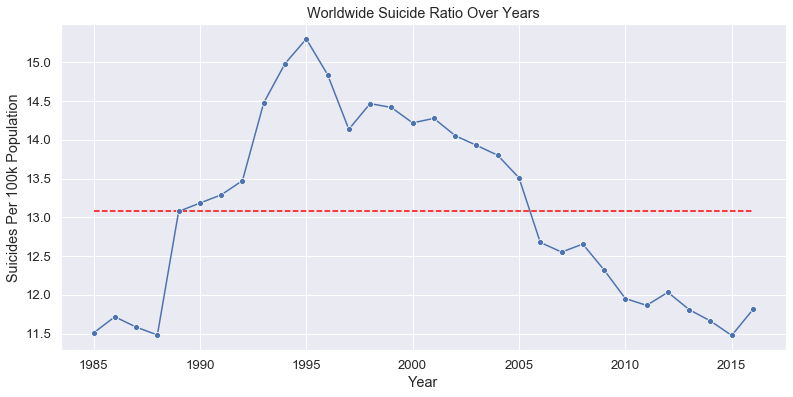

In [36]:
# plot the overall suicide ratio over all years
#group by countries to get ready to calculate suicide rate
suicideYear=df4.groupby('year').sum()[['suicides_no','population']].reset_index() 
#recalculate the ratio after grouping by year
suicideYear['suicides_per_100k'] = suicideYear.suicides_no/suicideYear.population*100000 


# Plotting the overall trend for suicide ratio
plt.figure(figsize=(13,6))
sns.lineplot('year', 'suicides_per_100k', data=suicideYear, marker = 'o')
plt.title("Worldwide Suicide Ratio Over Years")
plt.xlabel("Year")
plt.ylabel("Suicides Per 100k Population")
#add a average line of suicide rate into the plot
plt.hlines(suicideYear.suicides_per_100k.mean(), suicideYear.year.min(), suicideYear.year.max() ,colors = 'red', linestyles = 'dashed')

Text(0, 0.5, 'Suicides Number')

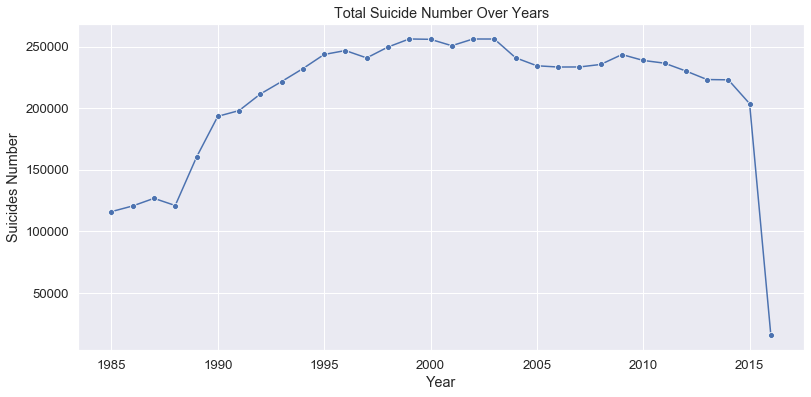

In [49]:
# plot the overall suicide number over all years

suicideYear=df4.groupby('year').sum()[['suicides_no','population']].reset_index() 

# Plotting the overall trend for suicide number
plt.figure(figsize=(13,6))
sns.lineplot('year', 'suicides_no', data=suicideYear, marker = 'o')
plt.title("Total Suicide Number Over Years")
plt.xlabel("Year")
plt.ylabel("Suicides Number")
#plt.hlines(suicideYear.suicides_per_100k.mean(), suicideYear.year.min(), suicideYear.year.max() ,colors = 'red', linestyles = 'dashed')

### Investigate the big gap from 1988 to 1989

In [39]:
#Build a data frame of suicide rate for each country each year
#calculte suicide rate for each country each year
topcty = df4.groupby(['country','year'])[['suicides_no', 'population']].sum().reset_index() 
topcty['suicides_per_100k']= topcty.suicides_no/topcty.population*100000 
topcty.head()

,country,year,suicides_no,population,suicides_per_100k
0,Albania,1987,73,2709600,2.694125
1,Albania,1988,63,2764300,2.279058
2,Albania,1989,68,2803100,2.425886
3,Albania,1992,47,2822500,1.665190
4,Albania,1993,73,2807300,2.600363


In [40]:
# Top countries contributing to big gap from 1988 to 1989
#create a dataframe delta89 recording suicide rate for each country each year

tmp = topcty[['country', 'year', 'suicides_per_100k']].copy() # a copy of topcty
tmp = tmp.pivot(index = 'country', columns = 'year', values =  'suicides_per_100k') #reform the dataframe for easy access
gap = tmp[1989] - tmp[1988] #calculate the suicide rate difference of 1988 and 1989 for each country
gap.sort_values(ascending=False).head() #find the countries with biggest jump

#Guyana and Malta are the two countries with highest gap from 1988 to 1989

country
Guyana      5.819801
Malta       4.293279
Uruguay     2.622758
Ukraine     2.287537
Barbados    1.668928
dtype: float64

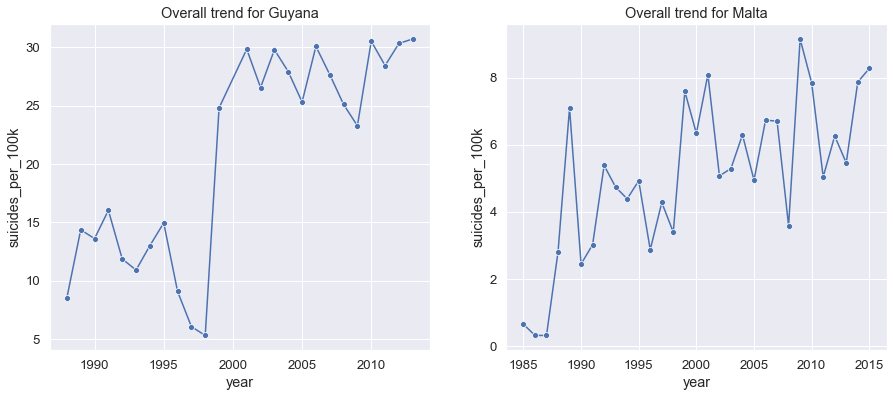

In [41]:
# Plot overall suicide trend for countries have larger jump in 1988 & 1989
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Overall trend for Guyana')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Overall trend for Malta')
# Filter Guyana's suicide rate and plot it versus year
topcty[topcty['country']=='Guyana']
sns.lineplot('year', 'suicides_per_100k', data=topcty[topcty['country']=='Guyana'], marker = 'o',ax=ax1)
topcty[topcty['country']=='Malta']
sns.lineplot('year', 'suicides_per_100k', data=topcty[topcty['country']=='Malta'], marker = 'o', ax=ax2)


### Data missing - Reason causing the big gap in 1989
#### Check how many countries being recorded each year

Text(0, 0.5, 'Number of Countries')

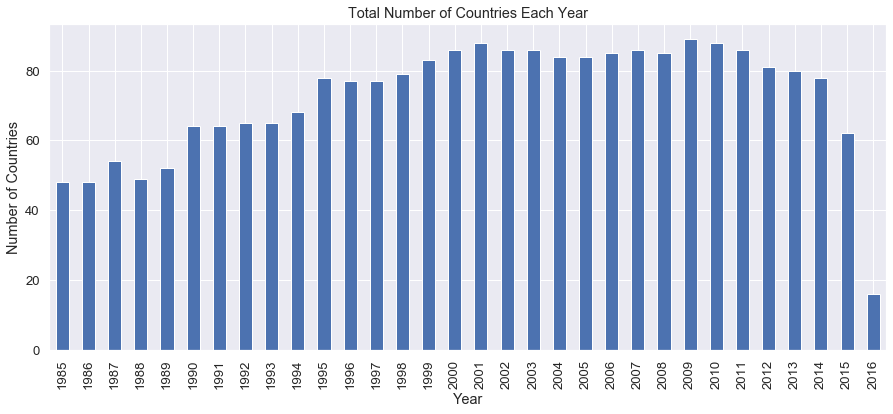

In [42]:
# Taking total number of countries each year into account 
countryByYear = topcty.groupby('year')['country'].nunique() #count how many countries being recorded each year in this data set

fig = plt.figure(figsize=(15,6)) #create a figure, set figure size
ax1 = fig.add_subplot(1, 1, 1) #create a axis
countryByYear.plot.bar(ax=ax1) #Bar plot for number of countries per year
ax1.set_title('Total Number of Countries Each Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Countries')


### Top 10 countries with highest suicide rates

In [50]:
# check the top 10 countries with highest suicide rates

topcountries = df4.groupby('country')[['suicides_no', 'population']].sum().reset_index()
topcountries['suicides_per_100k']= topcountries.suicides_no/topcountries.population*100000
top10=topcountries.sort_values(by= 'suicides_per_100k',ascending = False)[:10]
top10

,country,suicides_no,population,suicides_per_100k
51,Lithuania,28039,68085210,41.182219
74,Russia,1209742,3690802620,32.777207
86,Sri Lanka,55641,182525626,30.483939
10,Belarus,59892,197372292,30.344685
39,Hungary,73891,248644256,29.717558
50,Latvia,12770,44852640,28.471011
46,Kazakhstan,101546,377513869,26.898614
82,Slovenia,10615,40268619,26.360477
29,Estonia,7034,27090810,25.964525
95,Ukraine,319950,1286469184,24.870398


Text(0, 0.5, 'Suicides Per 100k Population')

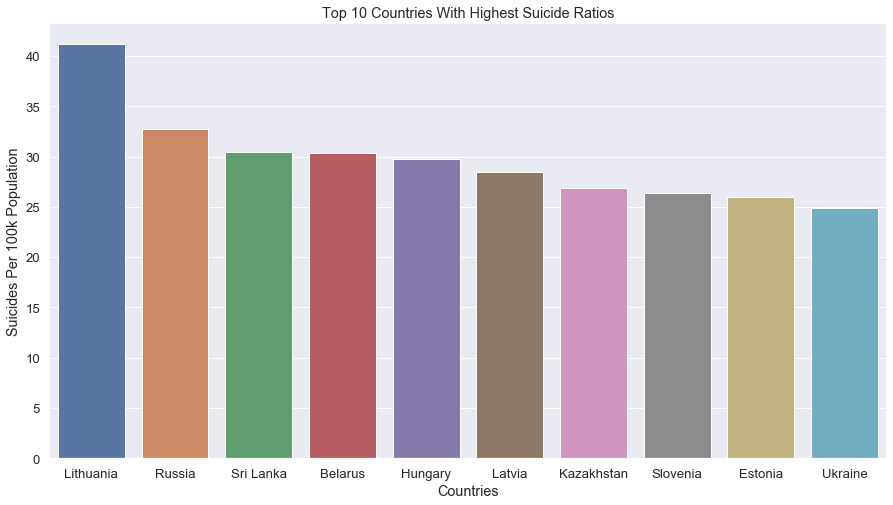

In [51]:
plt.figure(figsize=(15,8))
sns.barplot(x=top10.country,y=top10.suicides_per_100k)
plt.title("Top 10 Countries With Highest Suicide Ratios")
plt.xlabel("Countries")
plt.ylabel("Suicides Per 100k Population")

### Trend of suicide rate for top 5 countries

In [54]:
topcountry = topcty[topcty['country'].isin(top10.country.tolist()[0:5])] #Filter the data of the top 5 countries

country                5
year                  30
suicides_no          106
population           106
suicides_per_100k    107
dtype: int64

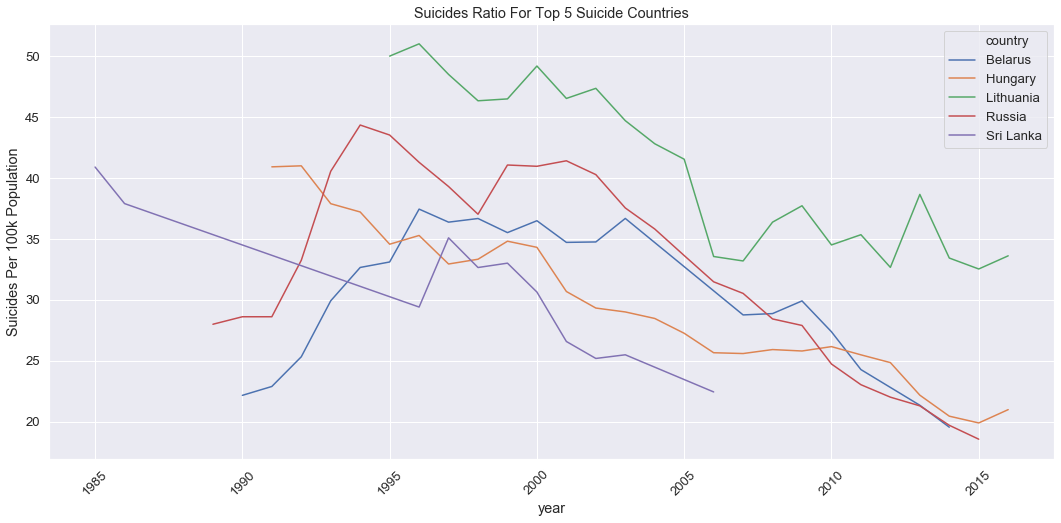

In [57]:
plt.figure(figsize=(18,8))
sns.lineplot(x='year',y='suicides_per_100k',hue=topcountry.country,data=topcountry)
plt.title("Suicides Ratio For Top 5 Suicide Countries")
plt.ylabel("Suicides Per 100k Population")
plt.xticks(rotation=45)
sns.set(font_scale=1)

#From the plot, Russian contributes most for the big gap from 1990 to 1995

### Rassia contributes most for the big gap from 1990 to 1995

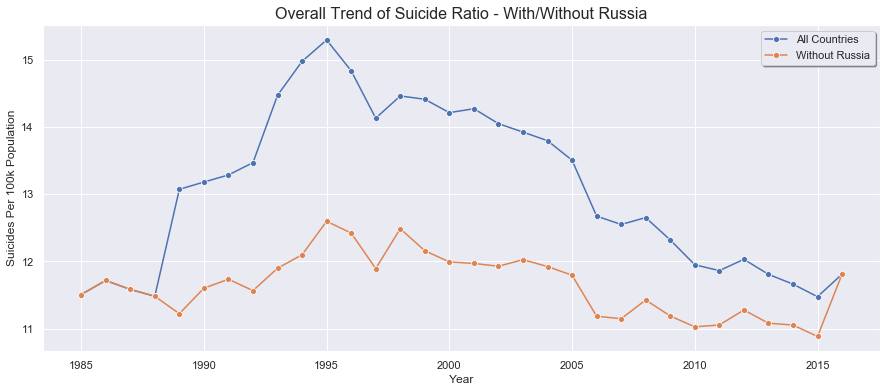

In [65]:
# Check overall suicide rate without Russia
withoutR = topcty[topcty['country']!='Russia'] #exclude Russia in the data set
withoutR = withoutR.groupby('year').sum()[['suicides_no','population']].reset_index() #recalulate suicide rates
withoutR['suicides_per_100k'] = withoutR.suicides_no/withoutR.population*100000
suicideYear['suicides_per_100k'] = suicideYear.suicides_no/suicideYear.population*100000

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
# plots for all countries
sns.lineplot('year', 'suicides_per_100k', data=suicideYear, ax=ax1, label="All Countries", marker='o')
# plot for all except Russia
sns.lineplot('year', 'suicides_per_100k', data=withoutR, ax=ax1, label="Without Russia", marker='o')

# adding title and legend etc.
plt.title('Overall Trend of Suicide Ratio - With/Without Russia',fontdict={'weight':'normal','size': 16})
plt.xlabel("Year")
plt.ylabel("Suicides Per 100k Population")
ax1.legend(loc='best', shadow=True)

### Investigate suicide rates for different age groups

In [80]:
#recalculate the overall suicide rate for different age groups
suicideByAge = df4.groupby(['year', 'age_group'])[['suicides_no', 'population']].sum().reset_index()
suicideByAge['suicides_per_100k']= suicideByAge.suicides_no/suicideByAge.population*100000
suicideByAge.groupby(['age_group']).sum()

,year,suicides_no,population,suicides_per_100k
age_group,,,,
1,62000,52264,8398693237,19.077297
2,64016,808542,8642946896,294.757632
3,64016,1123912,8438103587,421.779974
4,64016,2452141,14375888123,540.929141
5,64016,1658443,8803245340,606.889500
6,64016,653118,2663281253,813.617875


Text(0, 0.5, 'Suicides Per 100k Population')

<Figure size 936x432 with 0 Axes>

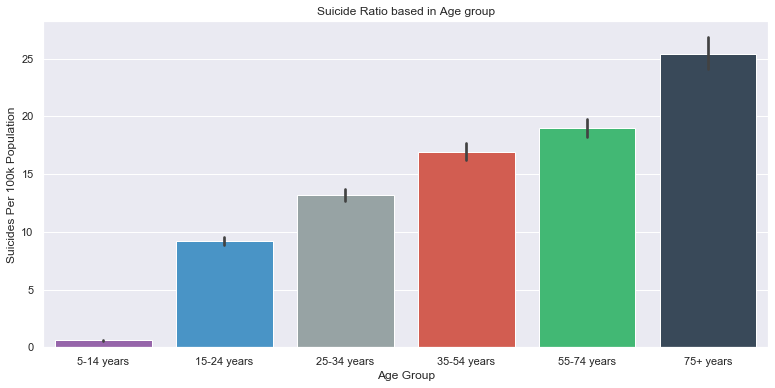

In [82]:
plt.figure(figsize=(13,6))#Suicide ratio based on age groups

#create labels for different age groups
en = {1:'5-14 years',
      2:'15-24 years',
      3:'25-34 years',
      4:'35-54 years',
      5:'55-74 years',
      6:'75+ years'}


plt.figure(figsize=(13,6))
color=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71","#34495e"]

#create bar plot for overall suicide rate for different age group
sns.barplot(x=suicideByAge.age_group.map(en.get), y=suicideByAge['suicides_per_100k'],palette=color)
plt.title("Suicide Ratio based in Age group")
plt.xlabel("Age Group")
plt.ylabel("Suicides Per 100k Population")

Text(0, 0.5, 'Suicides Per 100k Population')

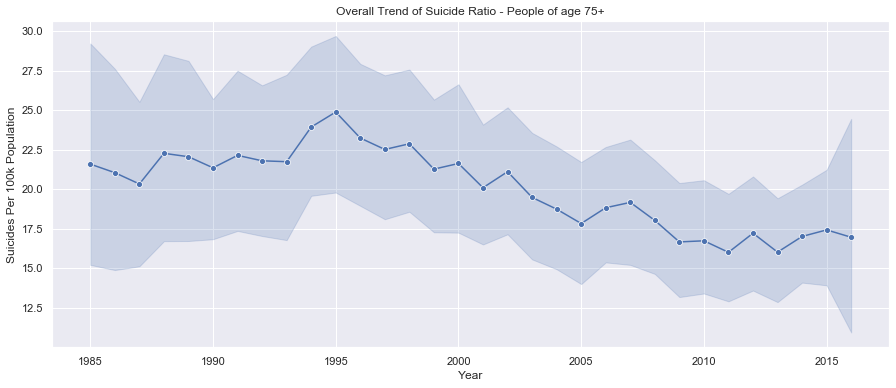

In [83]:
# analysis for age group: 75+

elderly = df4[suicide.age_group == 6].groupby(['year', 'country']).sum()[['suicides_no', 'population']].reset_index()
elderly['suicides_per_100k'] = elderly.suicides_no/elderly.population*100000

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
# suicide rate for people in the age group 75+
sns.lineplot('year', 'suicides_per_100k', data=elderly, ax=ax1, marker='o')

# adding title and label etc.
ax1.set_title('Overall Trend of Suicide Ratio - People of age 75+')
ax1.set_xlabel("Year")
ax1.set_ylabel("Suicides Per 100k Population")


Text(0, 0.5, 'Suicides Per 100k Population')

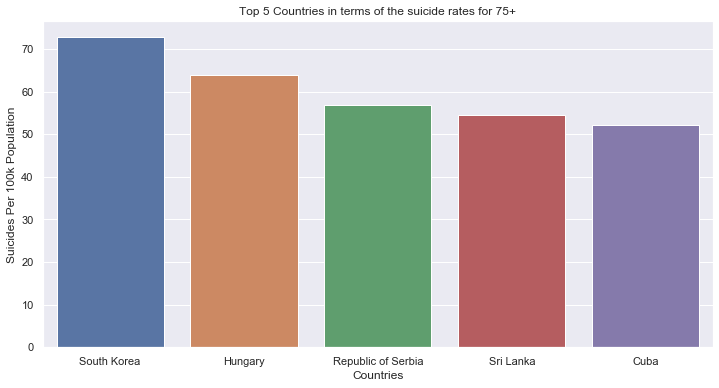

In [84]:
elderly = elderly.groupby(['country']).sum()[['suicides_no', 'population']].reset_index()
elderly['suicides_per_100k'] = elderly.suicides_no/elderly.population*100000
top5_elderly = elderly.sort_values(by='suicides_per_100k', ascending=False)[:5]
plt.figure(figsize=(12,6))
sns.barplot(x=top5_elderly.country,y=top5_elderly.suicides_per_100k)
plt.title("Top 5 Countries in terms of the suicide rates for 75+")
plt.xlabel("Countries")
plt.ylabel("Suicides Per 100k Population")


In [85]:
top5_elderly

,country,suicides_no,population,suicides_per_100k
84,South Korea,28026,38456864,72.876457
39,Hungary,10675,16738153,63.776451
72,Republic of Serbia,4874,8571800,56.860869
86,Sri Lanka,2340,4286751,54.586795
22,Cuba,6573,12597093,52.178705


Text(0, 0.5, 'Number of Suicide')

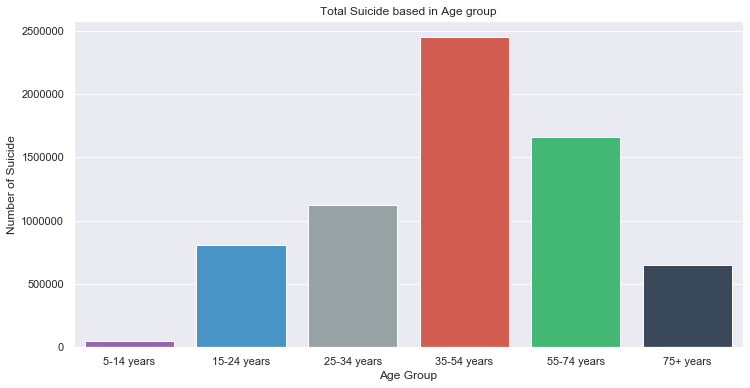

In [86]:
#Total suicide number based on age groups
totalAge = df4.groupby(['age_group']).sum()['suicides_no'].reset_index()
plt.figure(figsize=(12,6))
color=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71","#34495e"]

sns.barplot(x=totalAge.age_group.sort_values().map(en.get),y=totalAge.suicides_no, palette=color)
plt.title("Total Suicide based in Age group")
plt.xlabel("Age Group")
plt.ylabel("Number of Suicide")

### Suicide rate based on different age groups

Text(0, 0.5, 'Suicides Per 100k Population')

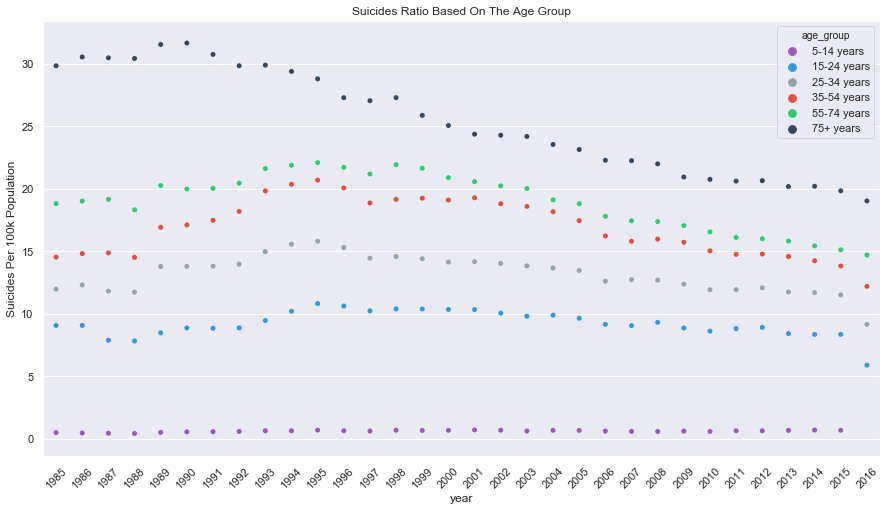

In [87]:

#Suicide Based on Year And Age
color=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71","#34495e"]
plt.figure(figsize=(15,8))
sns.swarmplot(x='year',y='suicides_per_100k',hue=suicideByAge.age_group.map(en.get),data=suicideByAge,palette=color)
plt.title("Suicides Ratio Based On The Age Group")
plt.xticks(rotation=45)
plt.ylabel("Suicides Per 100k Population")

### Suicide rate of different age group in different gender

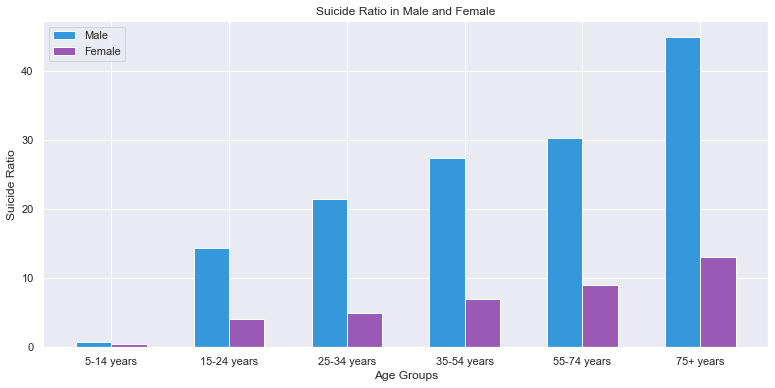

In [88]:
#Compare the suicide ratio fin Male and Female based on different age groups 

suicideByAgeGender = df4.groupby(['age_group','sex'])[['suicides_no', 'population']].sum().reset_index()

suicideByAgeGender['suicides_per_100k']= suicideByAgeGender.suicides_no/suicideByAgeGender.population*100000
suicideM_age = suicideByAgeGender[suicideByAgeGender.sex == 'male'].suicides_per_100k
suicideF_age = suicideByAgeGender[suicideByAgeGender.sex == 'female'].suicides_per_100k
index = np.arange(len(suicideF_age))
width = 0.3

plt.figure(figsize=(13,6))
plt.bar(index, height=suicideM_age, width=width, color= "#3498db", label='Male')
plt.bar(index+width, height=suicideF_age, width=width, color="#9b59b6", label='Female') #　width=index+width
plt.xlabel('Age Groups')
plt.ylabel('Suicide Ratio')
plt.title('Suicide Ratio in Male and Female')
plt.xticks(index + width / 2, ('5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years'))
plt.legend(loc='best')
plt.show()


In [89]:
# Data cleaning: for the "NA" value in HDI columns, we just drop them.
df4.drop(columns=['HDI for year']).dropna(axis=0,how='any')

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,total_gdp,gdp_per_capita,generation,HDI,age_group
36,Albania,1992,male,35-54 years,12,343800,3.49,Albania1992,709452584,251,Boomers,0.610,4
37,Albania,1992,male,15-24 years,9,263700,3.41,Albania1992,709452584,251,Generation X,0.610,2
38,Albania,1992,male,55-74 years,5,159500,3.13,Albania1992,709452584,251,Silent,0.610,5
39,Albania,1992,male,25-34 years,7,245500,2.85,Albania1992,709452584,251,Boomers,0.610,3
40,Albania,1992,female,15-24 years,7,292400,2.39,Albania1992,709452584,251,Generation X,0.610,2
41,Albania,1992,female,25-34 years,4,267400,1.50,Albania1992,709452584,251,Boomers,0.610,3
42,Albania,1992,female,35-54 years,2,323100,0.62,Albania1992,709452584,251,Boomers,0.610,4
43,Albania,1992,female,55-74 years,1,164900,0.61,Albania1992,709452584,251,Silent,0.610,5
44,Albania,1992,female,5-14 years,0,336700,0.00,Albania1992,709452584,251,Millenials,0.610,1
45,Albania,1992,female,75+ years,0,38700,0.00,Albania1992,709452584,251,G.I. Generation,0.610,6


### Relationship between suicide ratio, HDI for different countries

In [90]:
suicideDrop =df4.drop(columns=['HDI for year']).dropna(axis=0,how='any') #Drop previous HDI column because of too many NAs
#create a dataframe with HDI 
suicideHdi = suicideDrop.groupby(['year','country'])[['suicides_no', 'population']].sum().reset_index()
suicideHdi['suicides_per_100k']= suicideHdi.suicides_no/suicideHdi.population*100000 # calculte suicide rate for every country every year
hdi = suicideDrop.groupby(['year','country'])[['HDI']].mean().reset_index() # create HDI column for each country each year
suicideHdi['HDI']=hdi.HDI # add HDI column to the dataframe
suicideHdi.head()

,year,country,suicides_no,population,suicides_per_100k,HDI
0,1990,Argentina,2140,29091100,7.356202,0.704
1,1990,Armenia,93,2983700,3.116935,0.631
2,1990,Australia,2202,15807000,13.930537,0.866
3,1990,Austria,1825,7231353,25.237324,0.795
4,1990,Barbados,16,237000,6.751055,0.716


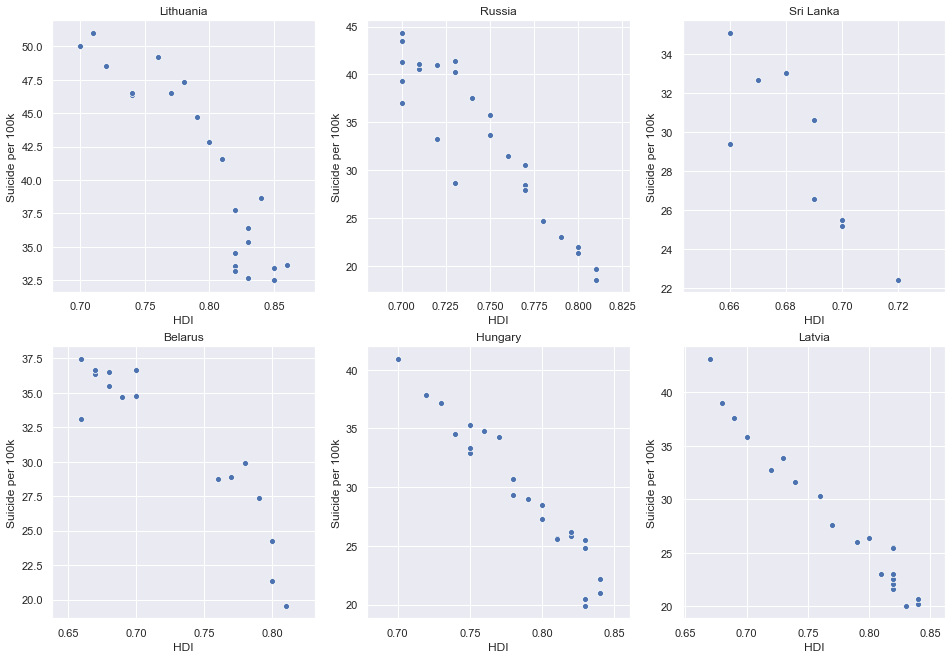

In [91]:
# Check HDI versus suicide rate for the top 10 suicide countries
suicideHdiForTop=suicideHdi[suicideHdi['country'].isin(top10.country)]
fig = plt.figure(figsize=(16,11))
for i in range(len(top10.country)-4):
    ax1=fig.add_subplot(2,3,i+1)
    df1=suicideHdiForTop[suicideHdiForTop['country']==top10.country.tolist()[i]]
    sns.scatterplot(x=df1.HDI.round(2) ,y=df1.suicides_per_100k, ax=ax1)
    ax1.set_title(top10.country.iloc[i])
    ax1.set_xlabel('HDI')
    ax1.set_ylabel('Suicide per 100k')
    

Text(0, 0.5, 'Suicides Per 100k Population')

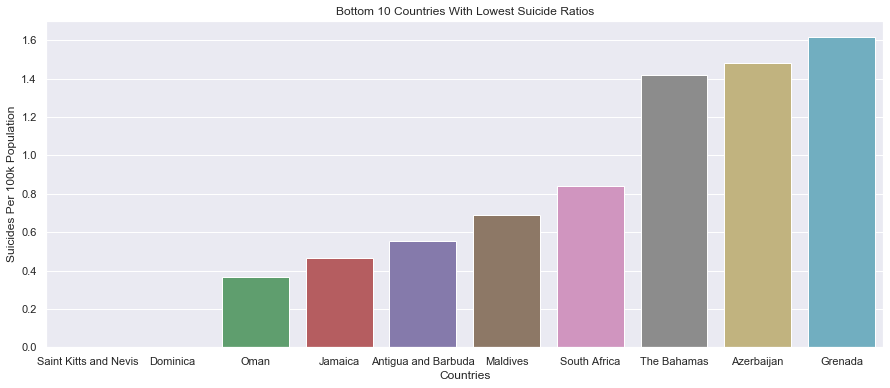

In [92]:
bottom10 = topcountries.sort_values(by= 'suicides_per_100k')[:10]
plt.figure(figsize=(15,6))
sns.barplot(x=bottom10.country, y=bottom10.suicides_per_100k)
plt.title("Bottom 10 Countries With Lowest Suicide Ratios")
plt.xlabel("Countries")
plt.ylabel("Suicides Per 100k Population")

# Gender Suicide Ratio Analysis

## read full data

In [ ]:
df = pd.read_csv('Full-Dataset.csv', sep =',')

## prepare the original dataframe
### select certain columns for gender analysis
### add a new column 'age_group' to store the order of age

In [93]:
df_gender = df4.loc[:,['country','year','sex','age','suicides_no','population','suicides/100k pop','HDI for year', 'HDI']]
df_gender.insert(3,'age_group',0)
df_gender.loc[df_gender['age']=='5-14 years','age'] = '05-14 years'
df_gender.loc[df_gender['age']=='5-14 years','age_group'] = 1
df_gender.loc[df_gender['age']=='15-24 years','age_group'] = 2
df_gender.loc[df_gender['age']=='25-34 years','age_group'] = 3
df_gender.loc[df_gender['age']=='35-54 years','age_group'] = 4
df_gender.loc[df_gender['age']=='55-74 years','age_group'] = 5
df_gender.loc[df_gender['age']=='75+ years','age_group'] = 6

## set global plot configurations

In [94]:
plt.rc('figure', figsize = (10,5))

## worldwide suicide ratio over 30 years per gender

sex              female       male
suicide_ratio  5.935839  20.714727


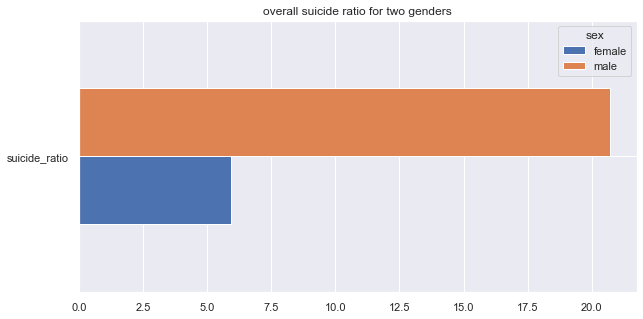

In [95]:
temp = df_gender.groupby('sex')[['suicides_no','population']].sum().reset_index()
temp = temp.assign(suicide_ratio=temp['suicides_no']/(temp['population']/100000))
ratio_all = pd.pivot_table(temp,values = 'suicide_ratio', columns = ['sex'])
print(ratio_all)
ratio_all.plot.barh(title = 'overall suicide ratio for two genders')

## suicide ratio vs. year per gender

Text(0, 0.5, 'suicide_ratio')

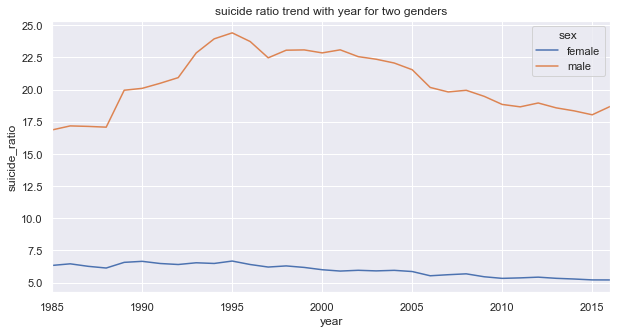

In [96]:
tmp = df_gender.groupby(['year','sex'])[['suicides_no','population']].sum()
tmp = tmp.assign(su_ratio_year = tmp['suicides_no']/(tmp['population']/100000))
ratio_year = tmp['su_ratio_year'].unstack()
ratio_year.plot(title = 'suicide ratio trend with year for two genders').set_ylabel('suicide_ratio')

## suicide ratio vs. age per gender

Text(0, 0.5, 'suicide_ratio')

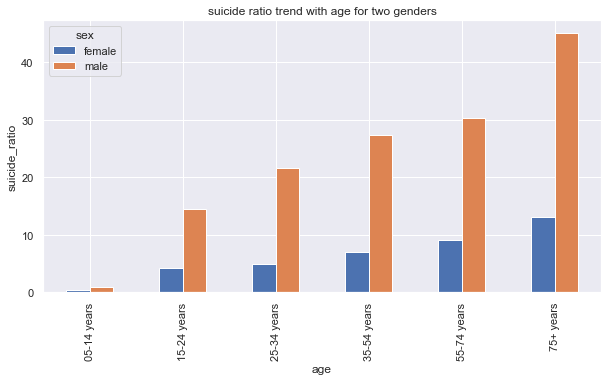

In [97]:
tmp = df_gender.groupby(['age','sex'])[['suicides_no','population']].sum()
tmp = tmp.assign(su_ratio_age = tmp['suicides_no']/(tmp['population']/100000))
ratio_age = tmp['su_ratio_age'].unstack()
ratio_age.plot.bar(title = 'suicide ratio trend with age for two genders').set_ylabel('suicide_ratio')

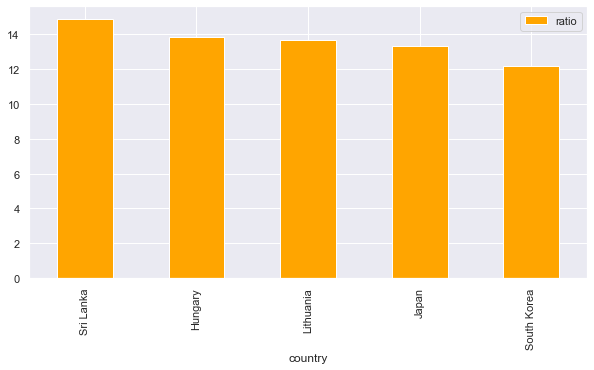

In [99]:
tmp = df_gender.groupby(['country','sex'])[['suicides_no','population']].sum().assign(ratio = tmp['suicides_no']/(tmp['population']/100000))
# tmp has multiIndex('country','sex'), we cannot select values by a single index in multiIndex, reset multiindex into column
tmp_reindex = tmp.reset_index()
female_top5 = tmp_reindex[tmp_reindex['sex']=='female'].sort_values(by = ['ratio'], ascending = False)[['country','ratio']].head(5)
female_top5.plot.bar(x= 'country', y = 'ratio', color = 'Orange')

## top 5 countries with highest suicide ratio per gender

Text(0.5, 0, 'overall suicide ratio')

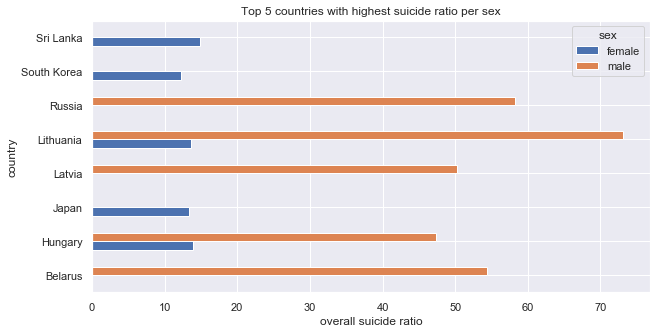

In [100]:
tmp = df_gender.groupby(['country','sex'])[['suicides_no','population']].sum().assign(ratio = tmp['suicides_no']/(tmp['population']/100000))
# tmp has multiIndex('country','sex'), we cannot select values by a single index in multiIndex, reset multiindex into column
tmp_reindex = tmp.reset_index()
# tmp is untouched
top5 = tmp_reindex.sort_values(by = ['ratio'], ascending = False).groupby('sex')[['country','sex','ratio']].head(5)
# select the top 5 countries by ratio in two sex groups (in one dataframe)
top5_sex = top5.pivot(index='country', columns='sex', values='ratio')
top5_sex.plot.barh(title = 'Top 5 countries with highest suicide ratio per sex').set_xlabel('overall suicide ratio')

# Data Analysis - Relationship between GDP and Suicide Rate

In [ ]:
%matplotlib inline

In [ ]:
data = pd.read_csv('Full-Dataset_HDi.csv')

In [ ]:
data.head()

In [102]:
sui_country = df4[['country', 'year', 'population','suicides_no','total_gdp']]
sui_country = sui_country.groupby([sui_country.country,sui_country.year],as_index = False).sum()
sui_country['new_suicide_rate'] = round(sui_country.suicides_no/sui_country.population * 100000,2)
#calculate suicide_rate by ourselves 

In [103]:
sui_country.head()

,country,year,population,suicides_no,total_gdp,new_suicide_rate
0,Albania,1987,2709600,73,25879498800,2.69
1,Albania,1988,2764300,63,25512000000,2.28
2,Albania,1989,2803100,68,28021499856,2.43
3,Albania,1992,2822500,47,8513431008,1.67
4,Albania,1993,2807300,73,14736852456,2.60


In [105]:
new_sr_ctr = sui_country.drop(columns = {'year','population','suicides_no','total_gdp'}).groupby(sui_country.country).mean().sort_values( 'new_suicide_rate',ascending =False).reset_index()

In [106]:
new_sr_ctr.head()

,country,new_suicide_rate
0,Lithuania,40.736818
1,Russia,32.702222
2,Sri Lanka,30.846364
3,Belarus,30.231429
4,Hungary,29.616923


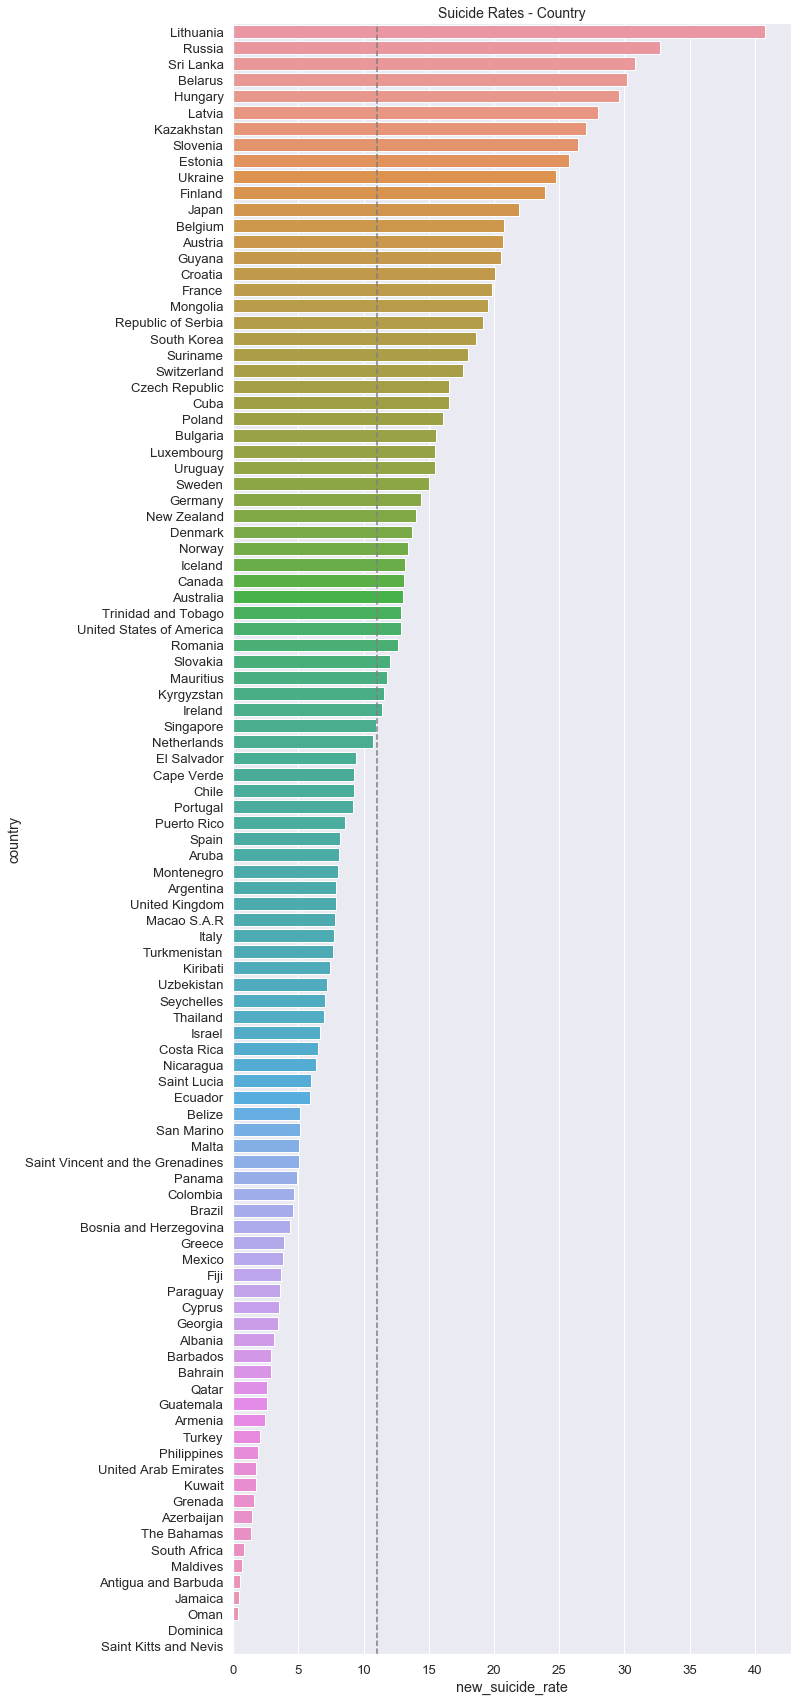

In [107]:
#suicide rate per country plot
plt.figure(figsize=(10,30))
plt.title('Suicide Rates - Country', fontsize=14)
plt.axvline(x=new_sr_ctr['new_suicide_rate'].mean(),color='gray',ls='--')
sns.barplot(data=new_sr_ctr, y='country',x='new_suicide_rate')

In [128]:
gdp_country = df4[['country', 'year', 'population','total_gdp']]
a = gdp_country.groupby(['country', 'year', 'total_gdp'], as_index=False).sum()
a['gdp_per'] = a['total_gdp']/a['population'] # calculate gdp_per country regardless of year 
a = a.drop(columns = ['total_gdp','population','year'])
a['suicide_rate'] = sui_country['new_suicide_rate']
a = a.groupby(a.country).mean().sort_values('gdp_per',ascending = False)

,gdp_per,suicide_rate
country,,
Luxembourg,68798.382349,15.510323
Qatar,68118.066055,2.618000
Switzerland,62994.406233,17.625238
Norway,57327.120150,13.376000
San Marino,53663.471079,5.140000
Denmark,49293.527302,13.702727
United Arab Emirates,42178.271560,1.751667
Sweden,41690.373421,14.999000
Iceland,39745.749406,13.214062


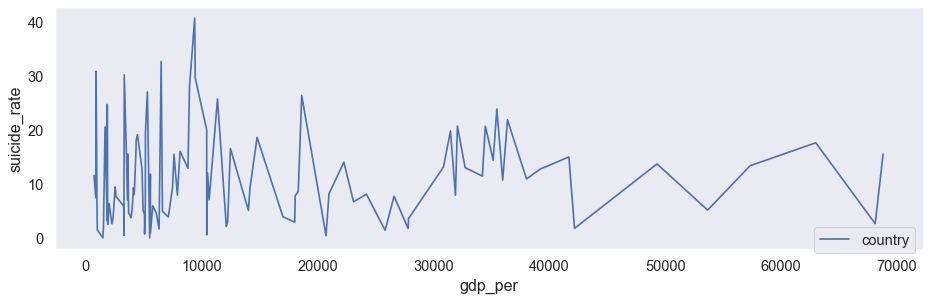

In [129]:
fig, ax1 = plt.subplots(1,1,figsize=(14,4), dpi=80, sharey=False)

sns.lineplot(data=a, y='suicide_rate', x='gdp_per', ax=ax1, label='country')
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1, 0.12))

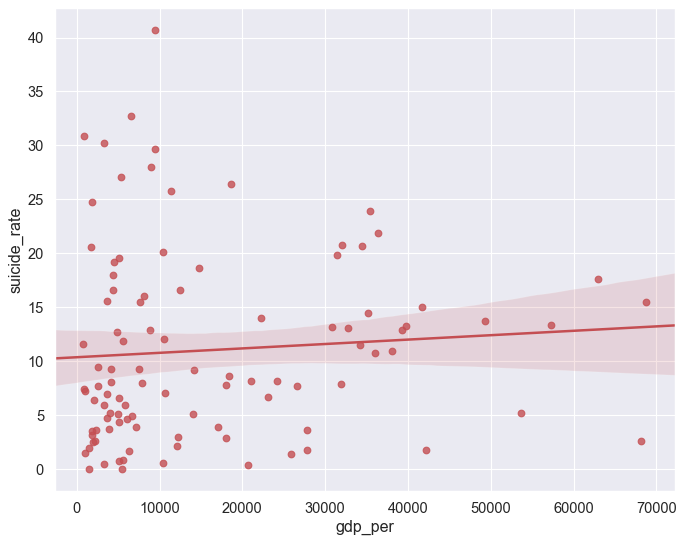

In [130]:
#overall trend of suicide_rate with gdp
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi=80, sharey=False)
sns.regplot(data = a, x='gdp_per',
              y='suicide_rate', ax=ax1, color='C3')

In [131]:
sui_country.head()

,country,year,population,suicides_no,total_gdp,new_suicide_rate
0,Albania,1987,2709600,73,25879498800,2.69
1,Albania,1988,2764300,63,25512000000,2.28
2,Albania,1989,2803100,68,28021499856,2.43
3,Albania,1992,2822500,47,8513431008,1.67
4,Albania,1993,2807300,73,14736852456,2.60


## Data Analysis - Relationship between HDI and Suicide Rate

In [136]:
HDI_country = df3.drop(['age', 'sex', 'suicides/100k pop', 'generation', 'HDI for year', 'gdp_per_capita ($)', 'country-year'], axis = 1)
HDI_country = HDI_country.groupby(['country', 'year', 'HDI', 'total_gdp']).sum().reset_index()
HDI_country['suicide_rate'] = ((HDI_country.suicides_no / HDI_country.population)*(10**5)).round(3)
HDI_country['gdp_per_capita'] = (HDI_country.total_gdp/HDI_country.population).round(2)
HDI_country = HDI_country[(HDI_country['country'] == 'Russia')|(HDI_country['country'] == 'Lithuania')|(HDI_country['country'] == 'Sri Lanka')|(HDI_country['country'] == 'Latvia')|(HDI_country['country'] == 'Hungary')]

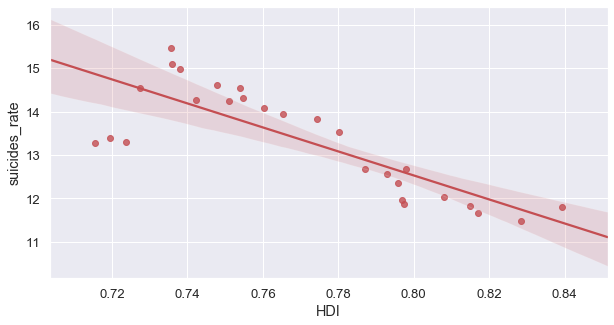

In [133]:
HDI_df = df3.drop(['age', 'sex', 'suicides/100k pop', 'generation', 'HDI for year', 'gdp_per_capita ($)', 'country-year'], axis = 1)
HDI_df = HDI_df.groupby(['country', 'year', 'HDI', 'total_gdp']).sum().reset_index()
HDI_df = HDI_df.groupby(['year']).mean().reset_index()
HDI_df['suicides_rate'] = ((HDI_df.suicides_no / HDI_df.population)*(10**5)).round(4)
HDI_df['gdp_per_capita'] = (HDI_df.total_gdp/HDI_df.population).round(2)
sns.regplot(x = 'HDI', y = 'suicides_rate', data = HDI_df, fit_reg = True, color = 'r')

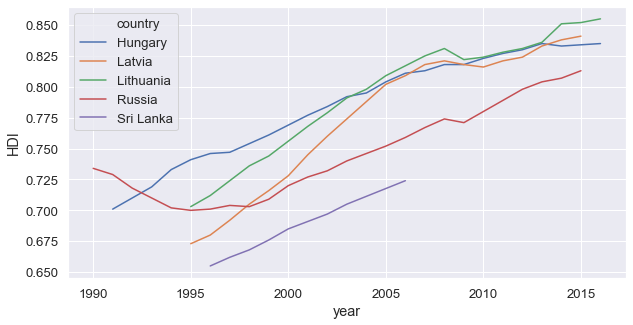

In [137]:
sns.lineplot(x = 'year', y = 'HDI', data = HDI_country, hue = 'country')

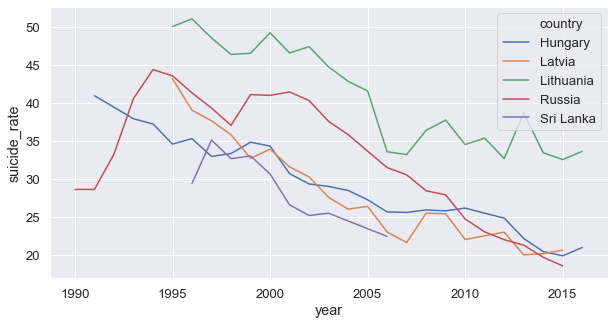

In [138]:
sns.lineplot(x = 'year', y = 'suicide_rate', data = HDI_country, hue = 'country')

## Web scraper to import developing and developed country information 

In [ ]:
#web scraper to import developing and developed country information 
url = "http://worldpopulationreview.com/countries/developed-countries/"

# Use requests to load the url
page = requests.get(url)

# Create a BeautifulSoup object
soup = soup(page.content, 'html.parser')

# pull all the texts of the 'table table-striped' class from the page
table = soup.find(class_ = 'table table-striped')

# pull text from all instances of <td> tag within the 'table table-striped' class
table2 = table.find_all('td')

countryname = []
index = 5
while index<len(table2):
    countryname.append(table2[index].getText())
    index = index+4
print(countryname)

In [ ]:
d1 = data[['country', 'year', 'population','suicides_no','gdp_year']]
d1= d1.groupby([d1.country,d1.year],as_index = False).sum()
d1['new_suicide_rate'] = round(d1.suicides_no/d1.population * 100000,2)

In [ ]:
d2 = data[['country', 'year', 'population','gdp_year']]
d2 = d2.groupby([d2.country,d2.year],as_index = False).sum()
d2['gdp_unique'] = np.array(data.gdp_year.unique())
d2['gdp_per'] = round(d2['gdp_unique']/d2['population'])
d2['new_suicide_rate'] = d1.new_suicide_rate
d2 = d2.drop(columns = {'population','gdp_year','gdp_unique'})

In [ ]:
inde = d2.country.isin(countryname)
ind_inverse = [not i for i in inde]
d2_develop = d2[inde]
d2_developin = d2[ind_inverse]

In [ ]:
#overall trend of suicide rate versus gdp 
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi=80, sharey=False)
sns.regplot(data = d2, x='gdp_per',
              y='new_suicide_rate', ax=ax1, color='C1')

In [ ]:
#developed coutry's suicide rate vs. gdp per capita 
d2_develop = d2_develop.groupby('year').mean()[['new_suicide_rate','gdp_per']]
d2_develop.head(10)

In [ ]:
#developing coutry's suicide rate vs. gdp per capita 
d2_developin = d2_developin.groupby('year').mean()[['new_suicide_rate','gdp_per']]
d2_developin.head(10)

In [ ]:
#developing country plot 
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi=80, sharey=False)
sns.regplot(data = d2_developin, x='gdp_per',
              y='new_suicide_rate', ax=ax1, color='C1')

In [ ]:
#developed country plot 
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi=80, sharey=False)
sns.regplot(data = d2_develop, x='gdp_per',
              y='new_suicide_rate', ax=ax1, color='C8')

In [ ]:
# correlation heat map 
fig, ax = plt.subplots(figsize=(10, 8))
hm = sns.heatmap(data[['year','suicides_no','population','suicide_rate','gdp_year','gdp_per_capita','HDI']].corr(), annot = True, ax = ax, cmap = "PiYG",fmt = '.2f',
                 linewidths = .05)
fig.subplots_adjust(top = 0.92)
fig.suptitle('Attributes Correlation Heatmap', fontsize = 20)
plt.show()

# Visualization Part

In [ ]:
import pandas as pd
import plotly.express as px

In [ ]:
suicides_dataset = pd.read_csv("suicides_rate_map.csv")
suicides_dataset.drop(columns = {"Unnamed: 0"}, inplace = True)
suicides_dataset['suicide_rate'] = (suicides_dataset.suicides_no / suicides_dataset.population)*10**5
suicides_dataset['suicide_rate'] = suicides_dataset['suicide_rate'].round(3)
suicides_dataset['gdp_per_capita'] = (suicides_dataset.total_gdp / suicides_dataset.population)
suicides_dataset['gdp_per_capita'] = suicides_dataset['gdp_per_capita'].round(2)
suicides_dataset.sort_values(by = ['year', 'country'], inplace = True)
suicides_dataset

In [ ]:
fig = px.choropleth(suicides_dataset, locations="country", locationmode="country names",
                    color="suicide_rate",
                    hover_name="country",
                    animation_frame="year",
                    animation_group="year",
                    labels={'suicide_rate':'Suicides per 100k population', 'year':'Year', 'country':"Country", 'gdp_per_capita':'GDP per capita ($)'},
                    color_continuous_scale=px.colors.carto.Sunset, #sequential.RdPu, carto.Sunset
                    title="Yearly global trend in suicides per 100k")
fig.show()
py.offline.plot(fig, filename= 'suicidesrate_interactve.html')